In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import os
import subprocess
plt.rc('text', usetex=True)

In [2]:
def get_grid(mx, my, mz, Lx,Ly,Lz):
    #print('mx,my,mz = ',mx,my,mz)
    ix, iy, iz = Lx*np.linspace(0,1,mx), Ly*np.linspace(0,1,my), Lz*np.linspace(0,1,mz)
    x, y, z = np.meshgrid(ix,iy,iz, indexing='ij')
    #print('ix', ix), print('iy', iy), print('iz', iz)
    return x,y,z

def plot_grid(x,y,z,T, t, filename):
    def plot_boundary_only(x,y,z,T):
        #mx, my, mz = x.shape
        x[1:-1, 1:-1, 1:-1],y[1:-1, 1:-1, 1:-1],z[1:-1, 1:-1, 1:-1],T[1:-1, 1:-1, 1:-1] = np.nan, np.nan, np.nan, np.nan \
                #This removes interior because we cannot see it anyway? reduces time to plot
        return x,y,z,T
    
    x,y,z,T = plot_boundary_only(x,y,z,T)   
    fig = plt.figure(figsize=(15,15), facecolor = 'w')
    ax = fig.add_subplot(111, projection='3d')
    img = ax.scatter(x,y,z, c=T.reshape(-1), s=150, vmin = -5, vmax = 30, cmap=plt.inferno())
    cbar = fig.colorbar(img, orientation='horizontal', fraction=0.047, pad=0.15, aspect=15)
    plt.tick_params(axis='both', which='major', labelsize=18)
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'Temperature ($^oC$)', size = 22)
    
    ax.text(0,0,-15, 't = %i days'%t, fontsize=20)
    ax.set_xticklabels(['%i'%(l*W/Nw) for l in ax.get_xticks()])
    ax.set_yticklabels(['%i'%(l*L/Nl/1e3) for l in ax.get_yticks()])
    ax.set_zticklabels(['%i'%(l*D/Nd) for l in ax.get_zticks()])
    ax.set_ylabel('Y (km)', labelpad=20, fontsize=20)
    ax.set_xlabel('X (m)', labelpad=20, rotation=0, fontsize=20)
    ax.set_zlabel('Depth from surface (m)', rotation=0, fontsize=20)
    ax.invert_zaxis()
    ax.view_init(15, -20)
    #plt.tight_layout()
    #plt.savefig('tempevolution_plots/temp%s.png'%count)
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
def init_T(x,y,z, T_3d):
    #print('size of y = ', np.shape(y))
    T = np.zeros_like(x)
    #print('Size of T = ',np.shape(T))
    T = T_3d
    return T


In [3]:
def show_plot(crust, t):
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    im = ax.imshow(crust, vmin=0, vmax=20, cmap = 'inferno', aspect = 1 * (Nw/Nd))
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('$\mathrm{Temperature\ [K]}$', rotation=270, labelpad=15)
    ax.set_title('$\mathrm{t = %i\ days}$'%t)
    ax.set_xlabel('$\mathrm{Width}$')
    ax.set_ylabel('$\mathrm{Depth}$')


In [4]:
# Constants (currently set for Earth vals)

Tinit = 10 # C
Tvar = 12 # C
Tbottom = 11 # C
Tday = 7 # C

# Diffusion constant (https://www.nature.com/articles/nature07818)
#alpha = 0.0864 # m^2 / day
alpha = 0.389 #m^2 / day (https://terra-docs.s3.us-east-2.amazonaws.com/IJHSR/Articles/volume4-issue3/2022_43_p17_Murgia.pdf)

# times 
tyear = 11.2 # days in a year of proxima b
tday = 1 # d
ti = 0 # d
tf = 20*tyear # d
dt = 0.05 # d

# Depth, width, length
D = 10 # m
Nd = 40
W = 40 # m
Nw = 50
L = 4e6 # m
Nl = 100
ad = D/Nd
al = L/Nl

In [19]:
# Read in flare info from Vida+2019
energy = np.genfromtxt('vida+2019_flares.txt', usecols=3, skip_header=2)
elen = len(energy)
# Probability of a flare occuring in dt = number of flares / number of dt in 50 days 
flare_prob = elen / (50/dt)

# energy = np.append(energy, 1e34)

# Ergs in a given dt:
pcen_energy = 6.03e30 * 24*60*60 * dt
flare_factor = 4.8*energy / pcen_energy * (Tinit+Tvar+Tday)

/var/folders/z6/ddv_qgs95hzfks0g6b5yc5480000gn/T/ipykernel_4262/237696044.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['%i'%(l*W/Nw) for l in ax.get_xticks()])
/var/folders/z6/ddv_qgs95hzfks0g6b5yc5480000gn/T/ipykernel_4262/237696044.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%i'%(l*L/Nl/1e3) for l in ax.get_yticks()])
/var/folders/z6/ddv_qgs95hzfks0g6b5yc5480000gn/T/ipykernel_4262/237696044.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(['%i'%(l*D/Nd) for l in ax.get_zticks()])


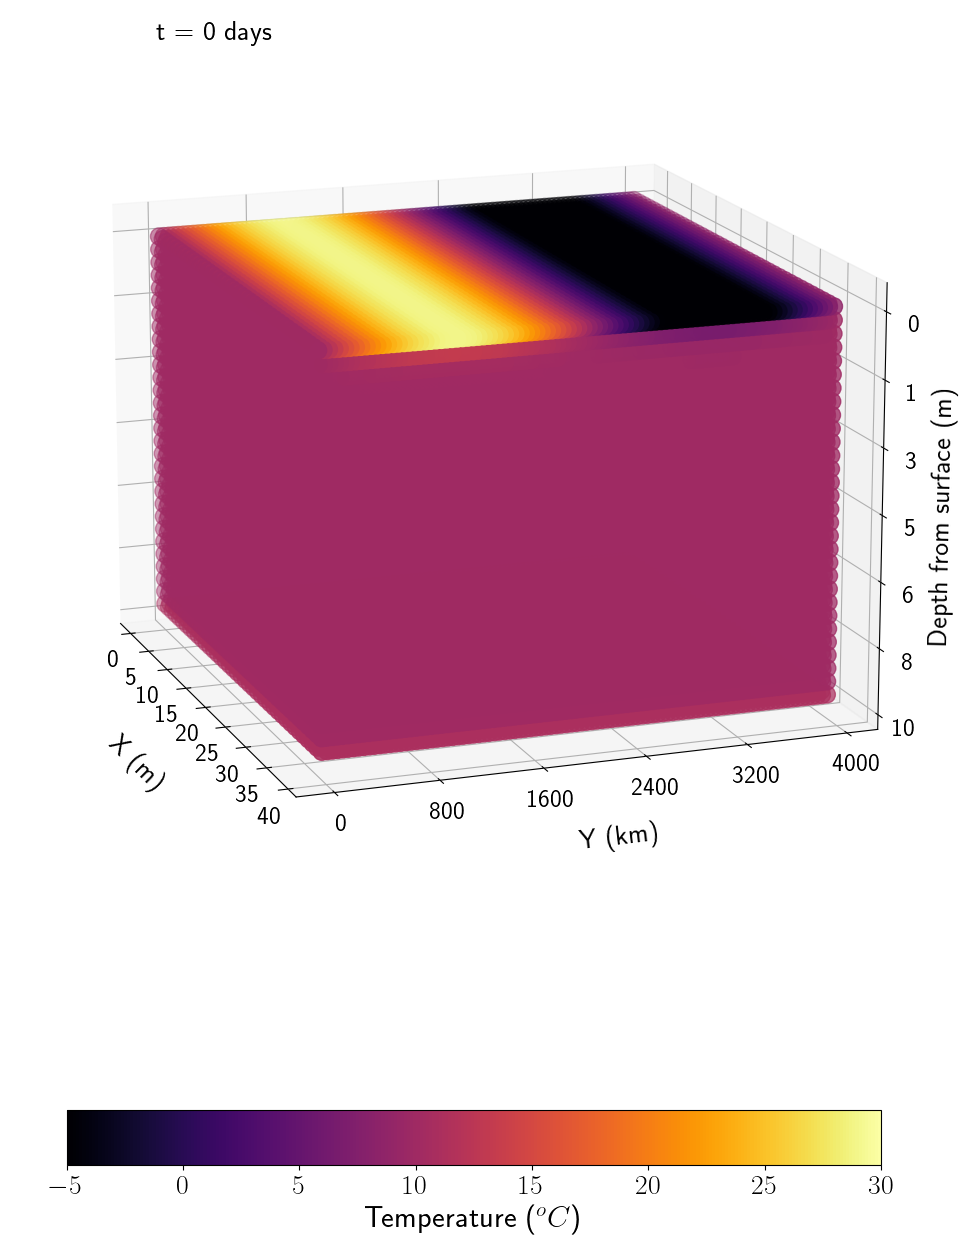

Careful, flare at t = 0.95 days! id = 57, Tchange = 2.47E-02 K 


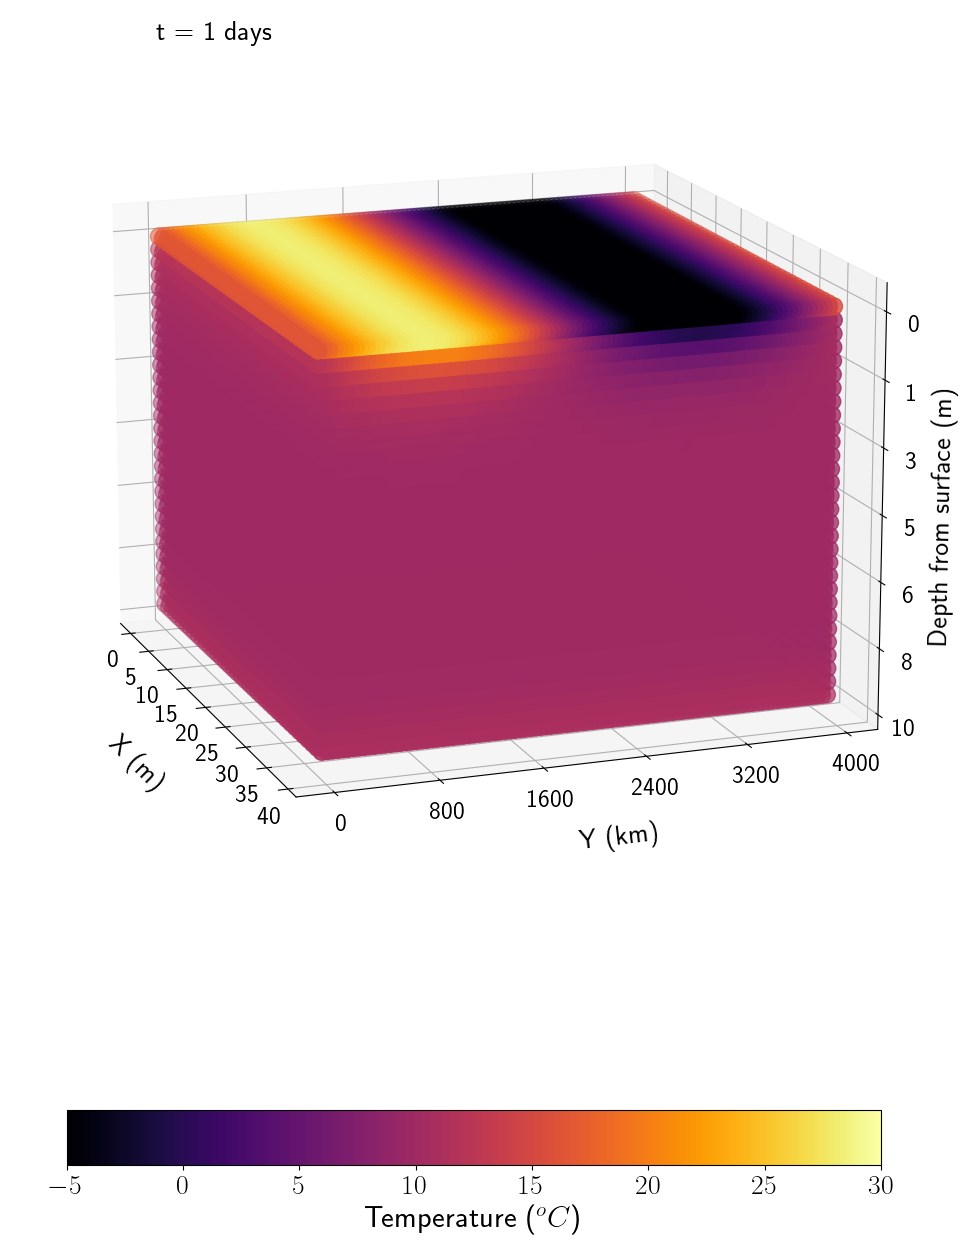

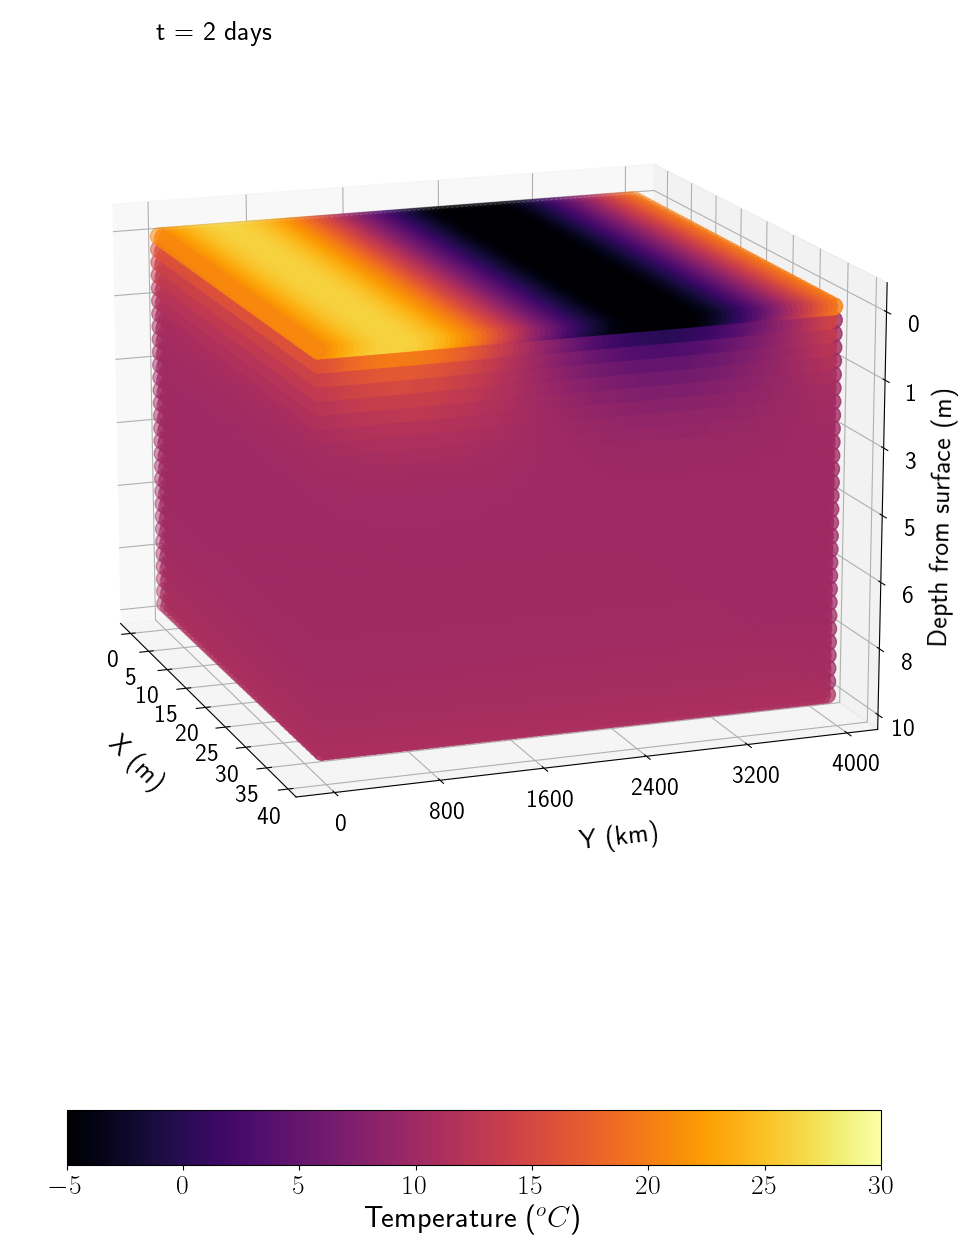

Careful, flare at t = 2.40 days! id = 18, Tchange = 1.26E-02 K 


KeyboardInterrupt: 

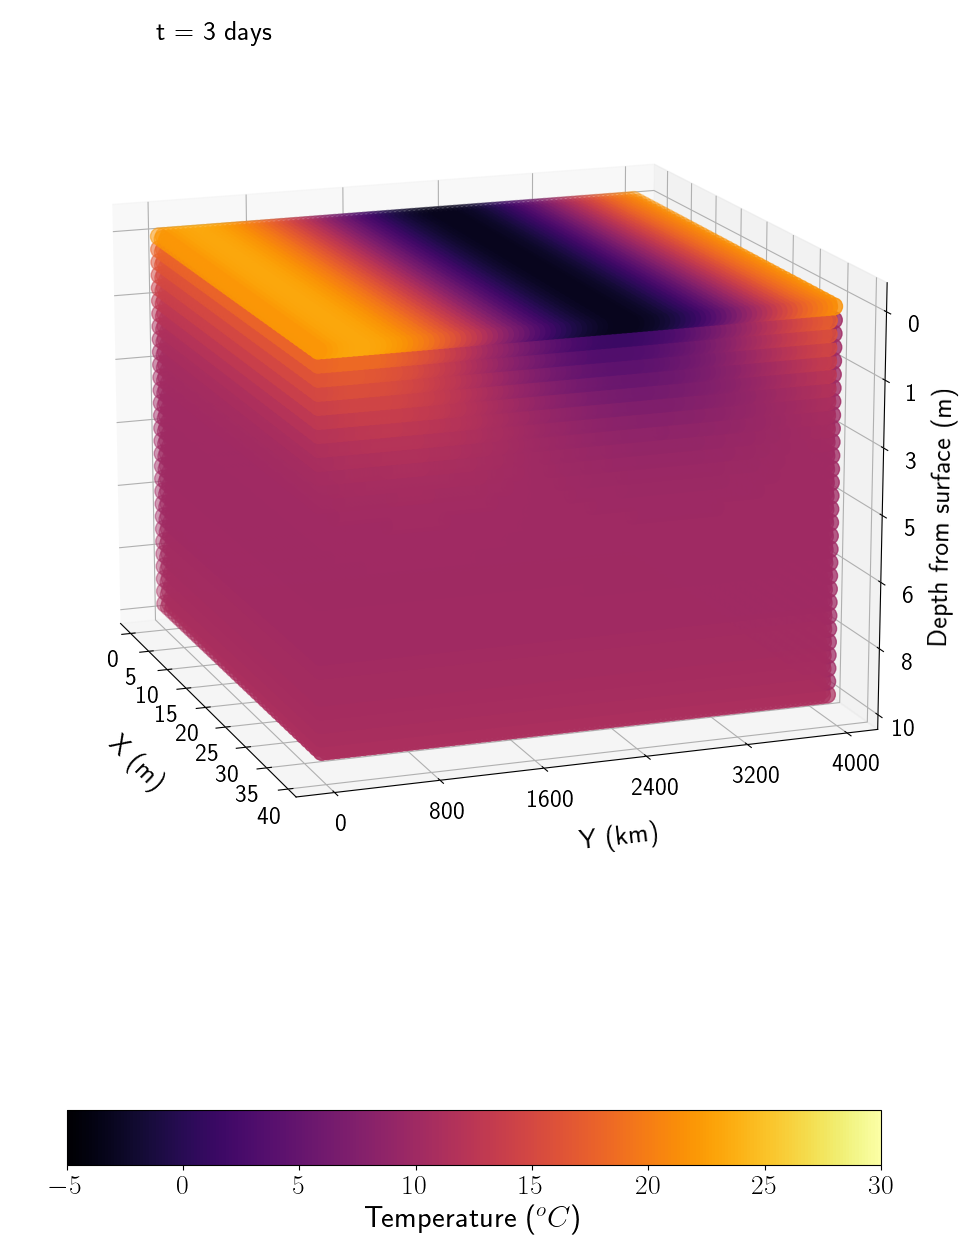

In [20]:
# Initialize "crust": 2D array of T = Tinit except at bottom
crust = np.full((Nd,Nl), Tinit, dtype='float')
crust[Nd-1] = Tbottom

count = 0

# Adjust dt to stability condition
if ((dt*alpha/ad**2 > 0.5) or (dt*alpha/al**2 > 0.5)):
        dt = 0.5*min(ad,al)**2/alpha
        print(t, ': dt adjusted to {}'.format(dt))

for t in np.arange(ti, tf+dt, dt):
    
    # Randomly choose if a flare happens; if yes, pick from the flare list. 
    if np.random.rand() < flare_prob:
        idx = np.random.randint(elen)
        flare_change = flare_factor[idx]
        print('Careful, flare at t = %.2f days! id = %i, Tchange = %.2E K '%(
            t, idx, flare_factor[idx]))
    else:
        flare_change = 0
    
    # Periodic heating at surface with phase shift and flaring
    phase = np.arange(Nl)/Nl
    crust[0] = (Tinit + 
                Tvar*np.sin(2*np.pi*(t/tyear+phase)) + 
                Tday*np.sin(2*np.pi*(t/tday + phase)) + 
                flare_change)
        
    # depth (skipping top and bottom to maintain boundaries)
    for i in range(1, Nd-1):
        # width (periodic boundary connecting 0 to Nw)
        for j in range(0, Nl-1):
            # evolve crust with FTCS approach! (in 2D)
            
            if j == Nl-1: # to avoid overflow at crust[i,j+1]
                crust[i,j] = crust[i,j] + dt*alpha*(
                    (crust[i+1,j] + crust[i-1,j] - 2*crust[i,j])/ad**2 + 
                    (crust[i,0] + crust[i,j-1] - 2*crust[i,j])/al**2)
            else:
                crust[i,j] = crust[i,j] + dt*alpha*(
                    (crust[i+1,j] + crust[i-1,j] - 2*crust[i,j])/ad**2 + 
                    (crust[i,j+1] + crust[i,j-1] - 2*crust[i,j])/al**2)
    
    # Show plot
#     if t%(tyear//5) == 0:
    if t%1 == 0:
        crust_3d = np.zeros((Nw,Nl,Nd))

        for i in range(Nw):
            crust_3d[i,:,:] = crust.T
        
        #show_plot(crust, t)
        #plt.show()
        nx, ny, nz = Nw, Nl, Nd
        Lx, Ly, Lz = nx-1, ny-1, nz-1
        x,y,z = get_grid(nx, ny, nz, Lx,Ly,Lz)  # generate a grid with mesh size Δx = Δy = Δz = 1
        T = init_T(x,y,z, crust_3d)
        filename = 'tempevolution_plots/temp'+str(count).zfill(3)+'.png'
        plot_grid(x,y,z,T, t, filename)
        #print('File {} saved \n'.format(filename))
        count += 1

#creating the animation
#print('Creating animation...')
#os.system('ffmpeg -i tempevolution_plots/temp%03d.png  -c:v libx264 -r 8 -pix_fmt yuv420p -vf \
#                    "scale=trunc(iw/2)*2:trunc(ih/2)*2" tempevolution_plots/surface_temp_final.mp4')
#print('animation created and saved')